# Tutorial for regression benchmarking

This code loads data and a design matrix, then benchmarks several methods of ridge regression.

Written by Michael Sokoletsky, 2023.


### Imports and opts

In [6]:
import seaborn as sns

import regbench as rb

opts = {}
opts['local_disk'] = 'D:\Churchland\Widefield'
opts['animal'] = 'mSM63' # Animal name
opts['rec'] = '09-Aug-2018' # Recording
opts['dtype'] = 'widefield' # Data type (choices: widefield)
opts['dformat'] = 'MATLAB' # Data format (choices: MATLAB, python)
opts['folds'] = 10 # Num of folds for cross-validation
opts['fs'] = 30 # frame rate
opts['frames_per_trial'] = 75 # Num of frames per trial
opts['methods'] = ['mml_simon', 'mml_sklearn']

### Load data and design matrix

In [7]:
data = rb.load_data(opts) # Load neural data object
design_df = rb.load_design_dframe(opts) # Load design DataFrame

### Benchmark methods of cross-validation

#### Method 1 - MML + Simon's ridge

In [16]:
m1_stack, m1_ridge = rb.cross_val_model(data, design_df, opts, method = 'mml_simon')

m1_corr = rb.model_corr(m1_stack, data)
rb.plot_model_corr(m1_corr)

Fold number:   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\michaeso.WISMAIN\OneDrive - weizmann.ac.il\Research\Analysis 2.0\regbench-main\regbench\ridge.py:360: RuntimeWarning: divide by zero encountered in log
  NLL_func = lambda L: - (q * np.log(L) - np.sum(np.log(L + d2[:q])) \


AttributeError: 'numpy.ndarray' object has no attribute 'SVT'

#### Method 2 - MML + Max's ridge

In [ ]:
c_ridge_MML = rb.ridge_MML(data.SVT.T, design_df, regress = False)


#### Method 3 - MML + sklearn's ridge

In [ ]:
m1_stack, m1_ridge = rb.cross_val_model(data, design_df, opts, method = 'mml_sklearn')


#### Method 4 - GridSearch CV + sklearn's ridge

#### Method 5 - Fminbound + sklearn's ridge

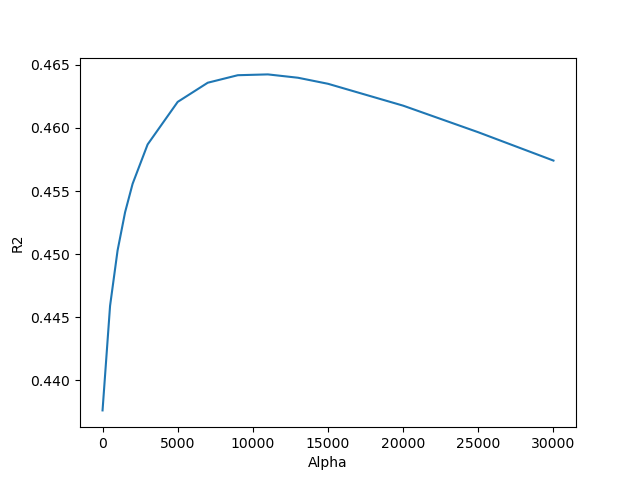

In [110]:
%matplotlib widget

import matplotlib.pyplot as plt
import mplcursors

fig = plt.figure()
lines = plt.plot(test_range, c_ridge_grid.cv_results_['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2')
mplcursors.cursor(lines)